# Strong Lensing: Time Delay Accuracy and Precision

_Phil Marshall & Lynne Jones_

In the first [Time Delay Challenge](http://timedelaychallenge.org) paper, [Liao et al (2015)](http://arxiv.org/pdf/1409.1254.pdf) derived the following simple model for how strongly gravitationally lensed quasar time delay accuracy (A), precision (P) and success rate (f) depend on the night-to-night cadence, season and campaign length. 

\begin{align}
|A|_{\rm model} &\approx 0.06\% \left(\frac{\rm cad} {\rm 3 days}  \right)^{0.0}
                          \left(\frac{\rm sea}  {\rm 4 months}\right)^{-1.0}
                          \left(\frac{\rm camp}{\rm 5 years} \right)^{-1.1} \notag \\
  P_{\rm model} &\approx 4.0\% \left(\frac{\rm cad} {\rm 3 days}  \right)^{ 0.7}
                         \left(\frac{\rm sea}  {\rm 4 months}\right)^{-0.3}
                         \left(\frac{\rm camp}{\rm 5 years} \right)^{-0.6} \notag \\
  f_{\rm model} &\approx 30\% \left(\frac{\rm cad} {\rm 3 days}  \right)^{-0.4}
                        \left(\frac{\rm sea}  {\rm 4 months}\right)^{ 0.8}
                        \left(\frac{\rm camp}{\rm 5 years} \right)^{-0.2} \notag
\end{align}

The first two of these metrics are candidate Figure of Merit proxies, while one can imagine combining all three somehow to provide an approximate dark energy parameter Figure of Merit. These three metrics are implemented in [`TdcMetric.py`](https://github.com/lsst/rubin_sim/blob/main/rubin_sim/maf/metrics/seasonMetrics.py) of the  [rubin_sim](http://github.com/lsst/rubin_sim) git repository. 

The Time Delay Challenge developed these heuristics based on in-depth analysis of time delays in a relatively 'constant' survey strategy. Newer survey strategies have a fully implemented form of 'rolling cadence' that are likely to impact these heuristics. 

This notebook provides a demo calculation of these metrics. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import rubin_sim.maf as maf
from rubin_sim.data import get_baseline

### Run the metric, as well as some associated season cadence and length metrics.

In [2]:
opsdb = get_baseline()
runName = os.path.split(opsdb)[-1].replace('.db', '')
print(runName)

baseline_v2.1_10yrs


Note that our metric (`TdcMetric`) is actually a "complex" metric, as it calculates A (accuracy), P (precision), and f (rate) in one go (thus re-using the cadence/season/campaign values which must also be calculated for each set of visits), and then has 'reduce' methods that separate each of these individual results into separate values. 

It does implement minimum limiting magnitude values before 'counting' a visit, as well as adding dust extinction to the m5 per visit values.

In [3]:
nside_tdc = 64
tdc_plots = [maf.HealpixSkyMap(), maf.HealpixHistogram()]
plotDict = {'xMin': 0.01, 'colorMin':0.01, 'percentileClip': 70, 'nTicks': 5}
tdc_summary = [maf.MeanMetric(), maf.MedianMetric(), maf.RmsMetric(), 
               maf.AreaThresholdMetric(upper_threshold=0.04)]
# Ideally need a way to do better on calculating the summary metrics for the high accuracy area.
slicer = maf.HealpixSlicer(nside=nside_tdc, use_cache=False)
tdcMetric = maf.TdcMetric(metric_name="TDC")
dustmap = maf.DustMap(nside=nside_tdc, interp=False)
bundle = maf.MetricBundle(
    tdcMetric,
    slicer,
    constraint=None,
    run_name=runName,
    plot_dict=plotDict,
    plot_funcs=tdc_plots,
    maps_list=[dustmap],
    summary_metrics=tdc_summary,
)
bundles = {'TDC': bundle}

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [4]:
outDir='test'
g = maf.MetricBundleGroup(bundles, opsdb, out_dir=outDir)
g.run_all()

Note that we now have more bundles in our bundle dictionary. These new bundles contain the results of the reduce functions - so, the metrics A, P, f separately as well as the "cadence", "season" and "campaign" diagnostics. 

In [5]:
bundles.keys()

dict_keys(['TDC', 'TDC_accuracy', 'TDC_cadence', 'TDC_campaign', 'TDC_precision', 'TDC_rate', 'TDC_season'])

If creating plots like this, we'd like to set the `plotDict` for each of these separately, so that we can get each plot to look "just right", and then we'll make the plots. When running in the script for the science radar, we can get approximately right by using `{'percentileClip': 70}` in the plotDict.

In [7]:
minVal = 0.01
maxVal = {'accuracy':0.04, 'precision':10.0, 'rate':40, 'cadence':14, 'season':8.0, 'campaign':11.0}
units = {'accuracy':'%', 'precision':'%', 'rate':'%', 'cadence':'days', 'season':'months', 'campaign':'years'}
for key in maxVal:
    plotDict = {'xMin':minVal, 'xMax':maxVal[key], 'colorMin':minVal, 'colorMax':maxVal[key]}
    plotDict['xlabel'] = 'TDC %s (%s)' % (key, units[key])
    bundles['TDC_%s' % (key)].set_plot_dict(plotDict)

/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/plots/plot_handler.py:587: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn(
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:148: UserWarning: Optimal bin calculation tried to make 112710643 bins, returning 200
  warnings.warn(
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:148: UserWarning: Optimal bin calculation tried to make 582 bins, returning 200
  warnings.warn(
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:148: UserWarning: Optimal bin calculation tried to make 4967 bins, returning 200
  warnings.warn(


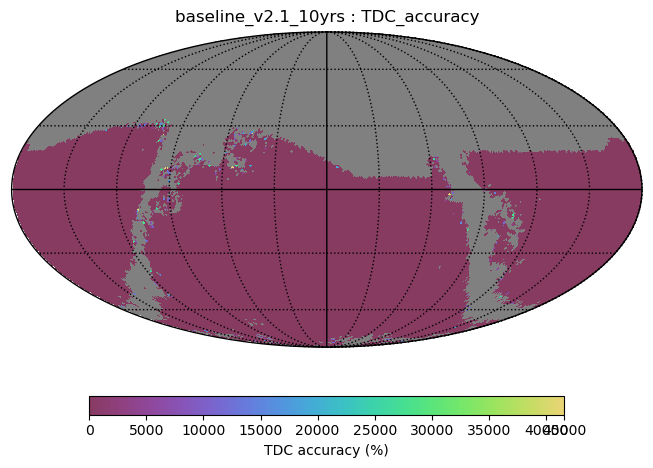

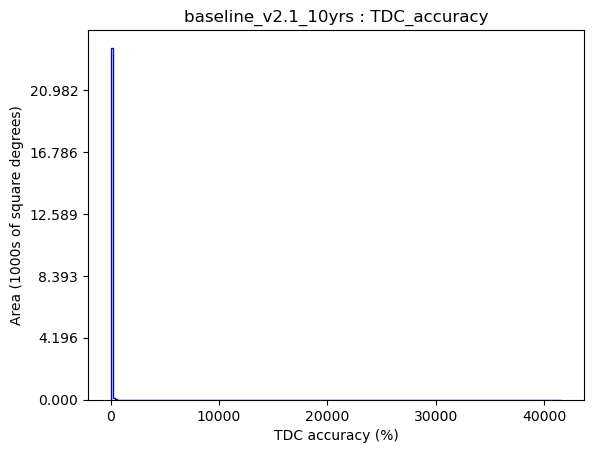

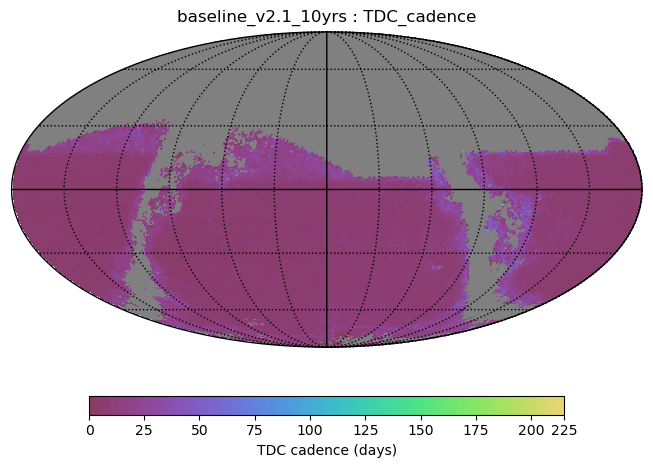

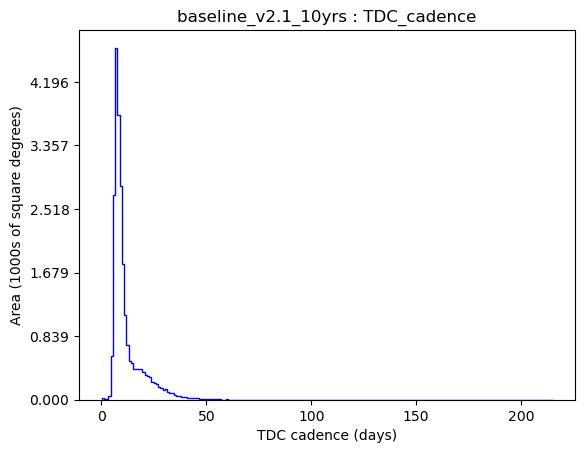

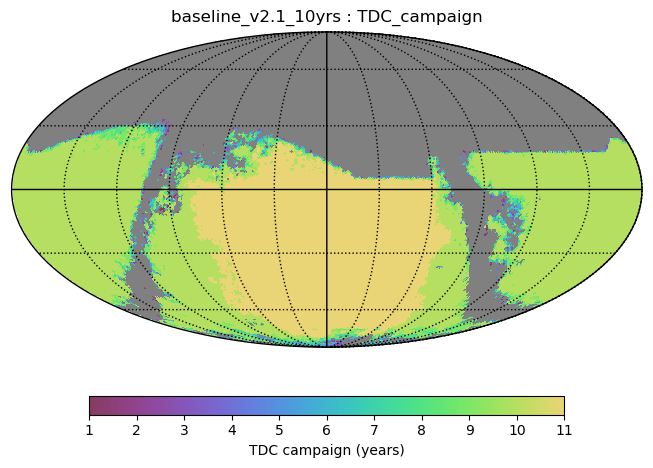

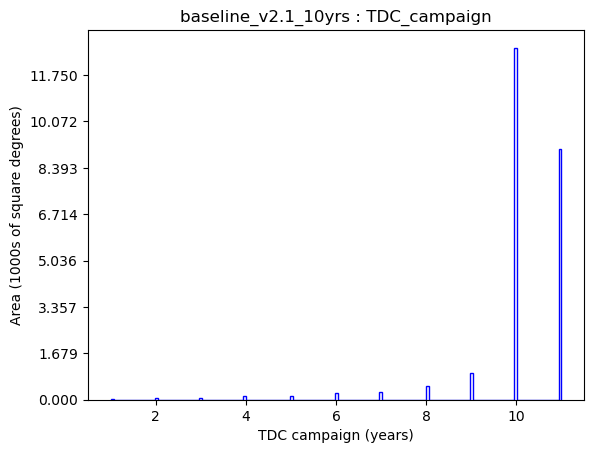

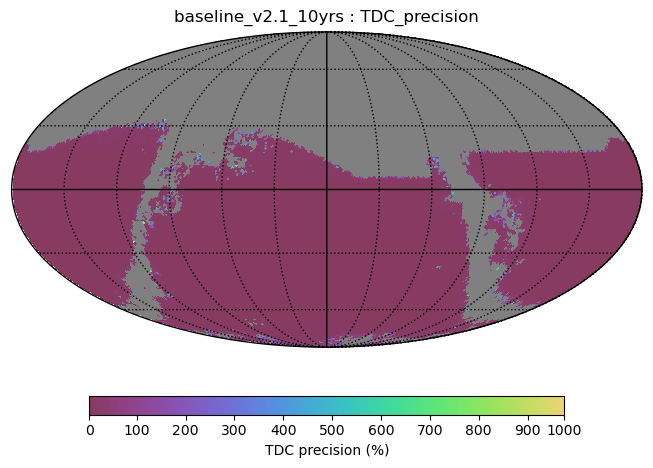

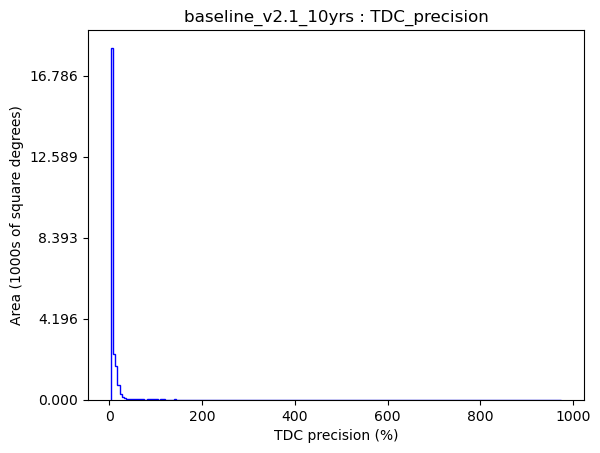

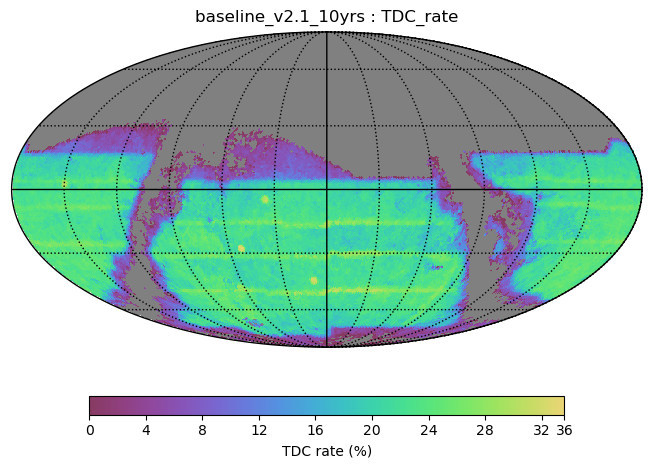

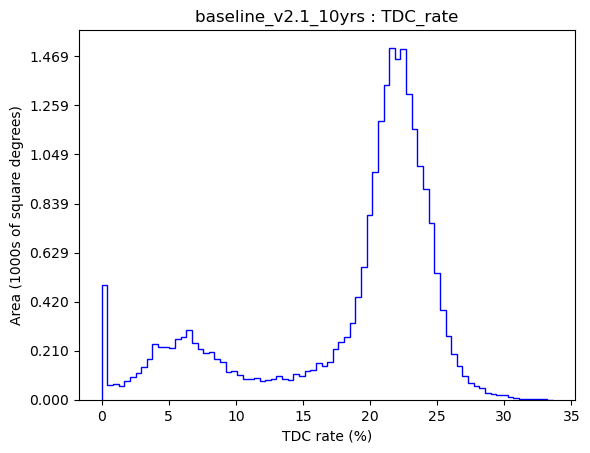

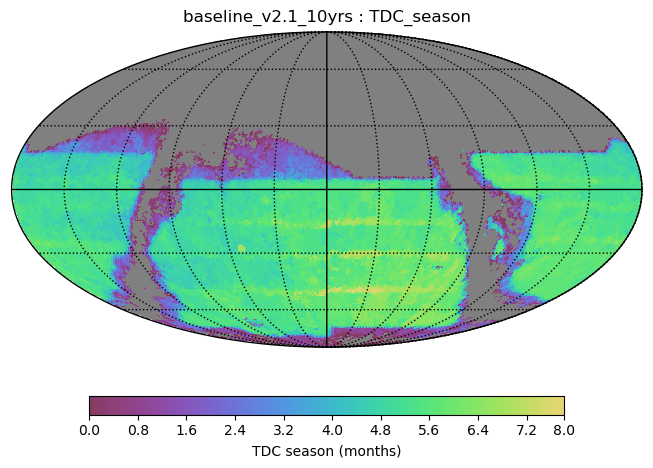

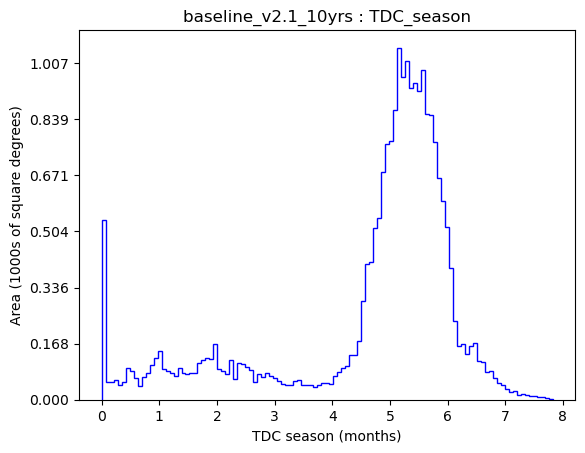

In [8]:
g.plot_all(closefigs=False)

In [9]:
bundle.metric_values

masked_array(data=[--, --, --, ...,
                   {'accuracy': 1116.336185035062, 'precision': 291.1799892782644, 'rate': 0.010071911588434696, 'cadence (days)': 16.666666666666668, 'season (months)': 0.00037709420988297403, 'campaign': 3},
                   --,
                   {'accuracy': 0.19657723704532576, 'precision': 175.43592417257724, 'rate': 11.955738194253016, 'cadence (days)': 215.0, 'season (months)': 7.170427018366414, 'campaign': 1}],
             mask=[ True,  True,  True, ..., False,  True, False],
       fill_value=-1.6375e+30,
            dtype=object)

Let's do some post-processing to turn the metric maps into single numbers for a table in the observing strategy white paper. (in the science Radar, we can't do this as easily, so just use the median values of each summary value; this will be fairly close to the "high accuracy" parts of the sky, as it's most of it). 

In [10]:
x = bundle.metric_values
index = np.where(x.mask == False)

In [11]:
f = np.array([each['rate'] for each in x[index]])
A = np.array([each['accuracy'] for each in x[index]])
P = np.array([each['precision'] for each in x[index]])
c = np.array([each['cadence (days)'] for each in x[index]])
s = np.array([each['season (months)'] for each in x[index]])
y = np.array([each['campaign'] for each in x[index]])
print(np.mean(f), np.mean(A), np.mean(P), np.mean(c), np.mean(s), np.mean(y))

18.459165403852158 88.2087338866476 10.9825095403001 11.76681745125569 4.646307434881192 10.107313857469988


We are only interested in lenses with high accuracy delays, i.e. the fraction of the survey area where the _A_ metric is below some threshold. We can turn this into a sky area if we know the average size of a `HEALPix` pixel.

In [12]:
accuracy_threshold = 0.04 # 5 times better than threshold of 0.2% set by Hojjati & Linder (2014).

high_accuracy = np.where(A < accuracy_threshold)
high_fraction = 100*(1.0*len(A[high_accuracy]))/(1.0*len(A))
print("Fraction of total survey area providing high accuracy time delays = ",np.round(high_fraction,1),'%')

high_accuracy_cadence = np.median(c[high_accuracy])
print("Median night-to-night cadence in high accuracy regions = ",np.round(high_accuracy_cadence,1),'days')

high_accuracy_season = np.median(s[high_accuracy])
print("Median season length in high accuracy regions = ",np.round(high_accuracy_season,1),'months')

high_accuracy_campaign = np.median(y[high_accuracy])
print("Median campaign length in high accuracy regions = ",int(high_accuracy_campaign),'years')

Fraction of total survey area providing high accuracy time delays =  83.4 %
Median night-to-night cadence in high accuracy regions =  8.3 days
Median season length in high accuracy regions =  5.3 months
Median campaign length in high accuracy regions =  10 years


In [13]:
Nside = 64
Npix = 12*Nside**2
Area_per_pixel = 4*np.pi / float(Npix) # steradians
Area_per_pixel *= (180.0/np.pi)*(180.0/np.pi) # square degrees
high_accuracy_area = len(A[high_accuracy])*Area_per_pixel
print("Area of sky providing high accuracy time delays = ",int(high_accuracy_area),"sq deg")

Area of sky providing high accuracy time delays =  20185 sq deg


In [14]:
precision_per_lens = np.array([np.mean(P[high_accuracy]),4.0])
precision_per_lens = np.sqrt(np.sum(precision_per_lens*precision_per_lens))
print("Mean precision per lens in high accuracy sample, including modeling error = ",np.round(precision_per_lens,2),'%')

fraction = np.mean(f[high_accuracy])
N_lenses = int((high_accuracy_area/18000.0) * (fraction/30.0) * 400)
print("Number of lenses in high accuracy sample = ",N_lenses)

distance_precision = (precision_per_lens * (N_lenses > 0)) / (np.sqrt(N_lenses) + (N_lenses == 0))
print("Maximum combined percentage distance precision (as in Coe & Moustakas 2009) = ",np.round(distance_precision,2),'%')

Mean precision per lens in high accuracy sample, including modeling error =  6.7 %
Number of lenses in high accuracy sample =  316
Maximum combined percentage distance precision (as in Coe & Moustakas 2009) =  0.38 %


The above overall precision can be related to the cosmological parameter precision, and so is a reasonable proxy Figure of Merit. This quantity is plotted by [Treu & Marshall (2016)](http://arxiv.org/abs/1605.05333) in their recent review: their target for the LSST era is between 0.4 and 0.7%.

# Conclusions

We no have good diagnostic and Figure of Merit metrics for assessing lens time delay measurement, based on extrapolating the TDC1 single filter catalog-level simulations. We see that we are *analysis-limited* in the sense that *if* we can combine the *ugrizy* light curves with such fidelity that they appear as if we had simply undertaken a single filter monitoring withthe same cadence, then we can achieve the TDC1 results of 400 accurate measurements and 0.25% precision in time delay distance, and hence (roughly) $H_0$ - but if we cannot, then time delay cosmography will be significantly degraded and we would need additional monitoring data.

## Look at summary values across multiple runs 



In [15]:
families = maf.archive.get_family_descriptions()
family_list = families.index.values
summaries = maf.get_metric_summaries()
metric_set = maf.get_metric_sets()

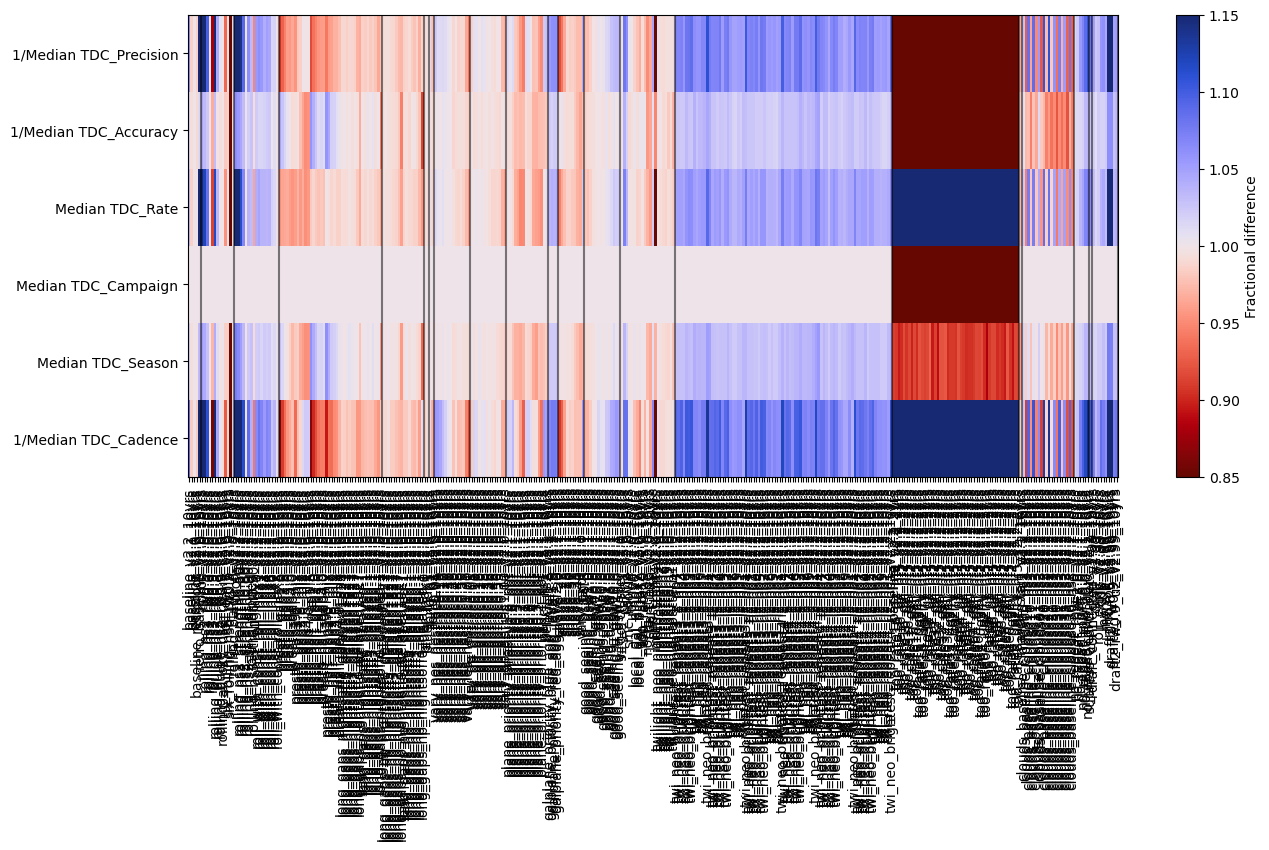

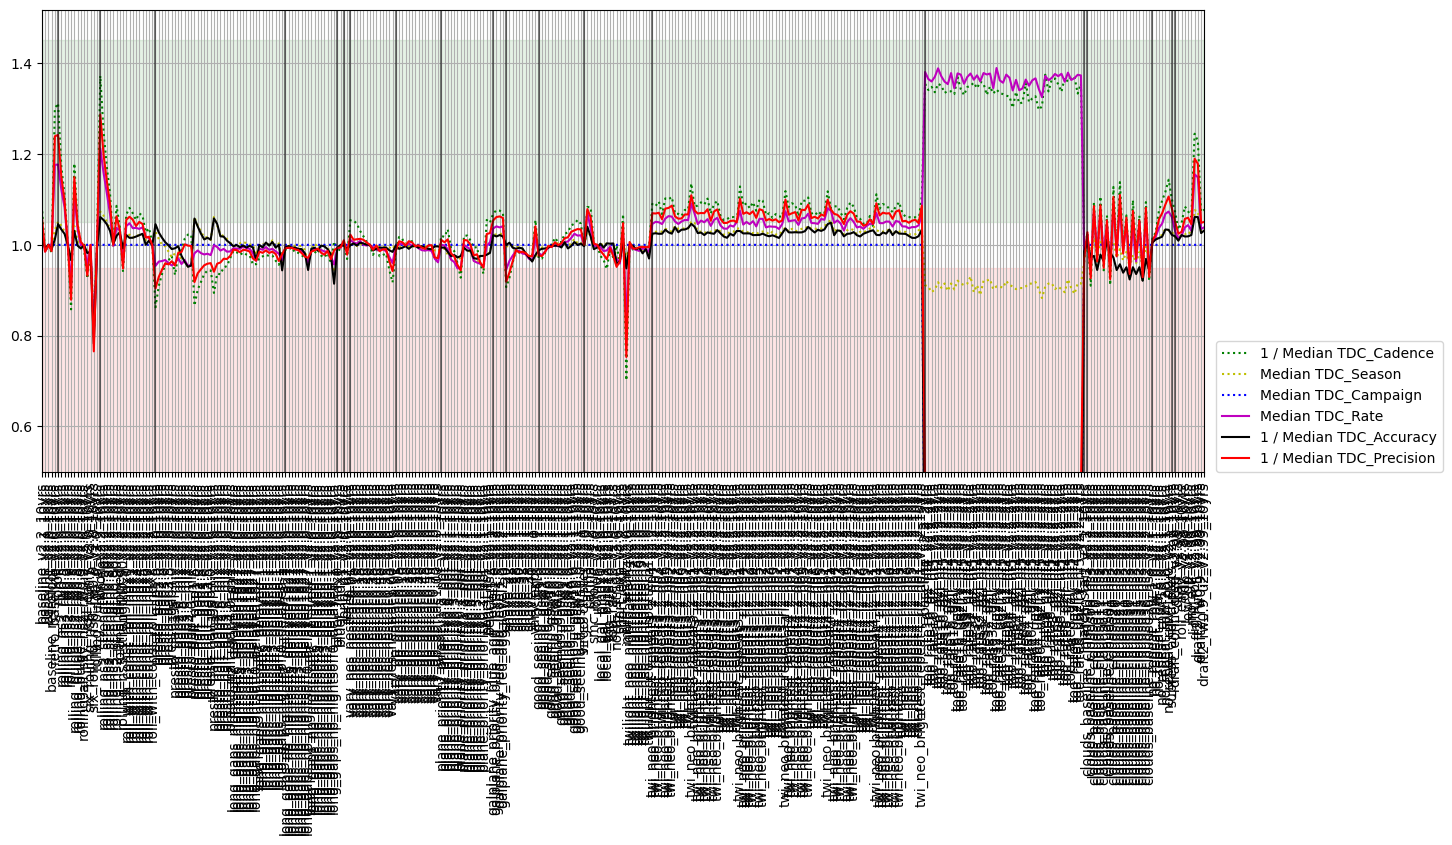

In [16]:
fams = [f for f in families.index if not f.startswith('ddf')]
these_runs = families.explode(['run']).loc[fams]['run']
baseline_run = 'baseline_v2.0_10yrs'
lines = maf.find_family_lines(families, fams)

kk = ['SL TDC']
for k in kk:

    # Plot two versions of the figures
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=metric_set.loc[k]['short_name'],
                                       metric_set=metric_set.loc[k],
                                      color_range=0.3)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)
        
for k in kk:
    
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    ylims = list(ax.get_ylim())
    if ylims[0] < 0.5:
        ylims[0] = 0.5
    if ylims[1] > 2:
        ylims[1] = 2
    ax.set_ylim(ylims)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

We see the greatest variation in the rolling cadence runs. The rolling cadence is potentially a weak spot for this metric; the rolling cadence distributes visits unevenly over time, which may not be captured appropriately by the TdcMetric (which uses a median of the season lengths and a mean of all season's cadence rates). The metric does add limiting magnitude cuts, so short exposures should be discounted. The suppress repeats series shows improvement, as the cadence should increase as visits are moved to different nights; a related series which moves visits among nights if the triplets family, which shows mixed effects. 